In [1]:
import sys
sys.path.append("/Volumes/pdoubraw-1/repos/ABLTools/python/")
sys.path.append("C:/Users/krydalch/Documents/Repos/ABLtools_python/")
import numpy as np
import matplotlib.pyplot as plt
import stochasticTurbulenceTools as stt
import glob, os
import pandas as pd

sys.path.append("C:/Users/krydalch/Documents/Repos/")
from datatools import wfip2
from datatools.remote_sensing import scintec_profiler

plt.rc("font",size=14)

# Import LLJ Profile via SODAR

In [2]:
sodar_path = "/Volumes/pdoubraw-1/repos/jet/data/"
sodar_path = "C:\\Users\\krydalch\\Desktop\\MetMastData\\SODAR\\"

df = wfip2.read_dir(dpath=sodar_path, reader=scintec_profiler, ext='mnd')
df = df.set_index("datetime")
# Remove Faulty Data
df = df.replace("99.99",None)
df = df.replace("999.9",None)

df['wind speed'] = df['wind speed'].astype(float)

time_vs_height = df[["wind speed","height"]].reset_index().set_index(["datetime","height"]).unstack().astype("float")
time_vs_height.index = time_vs_height.index.tz_localize("UTC")
df_sdr = time_vs_height.copy()

In [3]:
df_sdr.head()

wind speed                                      \
height                         30.0  40.0  50.0  60.0  70.0  80.0  90.0    
datetime                                                                   
2017-02-17 00:00:00+00:00       5.26  6.46  7.25  7.55  7.98  8.46  8.82   
2017-02-17 00:10:00+00:00       5.89  6.72  7.45  7.87  8.27  8.28  8.55   
2017-02-17 00:20:00+00:00       6.22  7.16  8.07  8.40  8.74  8.95  9.09   
2017-02-17 00:30:00+00:00       6.58  7.46  8.05  8.79  9.16  9.37  9.59   
2017-02-17 00:40:00+00:00       6.53  7.54  8.43  8.99  9.11  9.38  9.46   

                                              ...                          \
height                    100.0 110.0  120.0  ... 230.0 240.0 250.0 260.0   
datetime                                      ...                           
2017-02-17 00:00:00+00:00  9.11  9.30   9.43  ...  8.40  8.40  8.40  8.40   
2017-02-17 00:10:00+00:00  8.55  8.68   8.50  ...  6.83  7.81  7.29  8.08   
2017-02-17 00:20:00+00:00  9.27  9.32   9.38  ...  9.22  8.70  8.73  9.07   
2017-02-17 00:30:00+00:00  9.72  9.82   9.97  ...  8.37  8.30  7.18  7.69   
2017-02-17 00:40:00+00:00  9.55  9.62  10.06  ...  9.54  9.54  9.54  9.54   

                                                                  
height                    270.0  280.0  290.0  300.0 310.0 320.0  
datetime                                                          
2017-02-17 00:00:00+00:00  8.40   8.40   8.40   8.40  8.40  8.40  
2017-02-17 00:10:00+00:00  8.90   8.90   8.90   8.90  8.90  8.90  
2017-02-17 00:20:00+00:00  9.72  10.40  10.29  10.29  9.40  9.79  
2017-02-17 00:30:00+00:00  7.69   7.69   7.69   7.69  7.69  7.69  
2017-02-17 00:40:00+00:00  9.54   9.54   9.54   9.54  9.54  9.54  

[5 rows x 30 columns]

# Import Theory VP via TurbSim

In [31]:
kir_ts1 = stt.stochasticTurbulence("TurbSim")
#kir_ts.readBTS("/Users/pdoubraw/Downloads/")
kir_ts1.readBTS("C:/Users/krydalch/Desktop/TurbSim/bin/")

Opening file C:/Users/krydalch/Desktop/TurbSim/bin/TurbSim.bts...


# Plot 

Text(0.5, 1.0, 'VP LLJ vs PL')

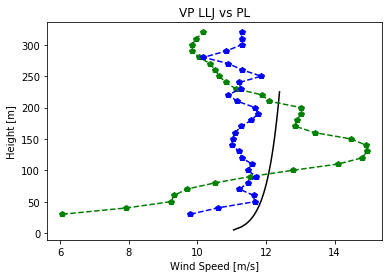

In [32]:
# Inputs
time_of_interest = "2017-02-17 14:40:00"
time_of_interest2 = "2017-02-17 18:20:00"
resamp_size = '10min'
# Plot TurbSim
u_TS1 = []
hs = []
i = 0
for z in kir_ts1.z:
    #print(np.mean(kir_ts.u[:,int(half_ind_y),i]))
    u_TS1 = np.append(u_TS1,np.mean(kir_ts1.u[:,0,i]))
    
    hs = np.append(hs, z)
    i = i + 1
plt.plot(u_TS1,hs,'k',label = 'TurbSim')

# Plot SODAR
resamp = df_sdr["wind speed"].resample(resamp_size).mean()
a = resamp.loc[time_of_interest]
b = resamp.loc[time_of_interest2]

plt.plot(a.values,a.index,"p--g",label = 'SODAR-LLJ')
plt.plot(b.values,b.index,"p--b",label = 'SODAR-mixed')
plt.ylabel('Height [m]')
plt.xlabel('Wind Speed [m/s]')
plt.title('VP LLJ vs PL')
#plt.savefig('Example_thry_1.png')

## Analyze the difference between LLJ VP and PL VP

### Check average velocity arcoss turbine area

In [33]:
alpha = 0.07
print('power law exp = ' , alpha)
print('\n')
# Rotor Span
MW10 = [30, 210]
MW5 = [30, 150]
MW3 = [30,150]

################################# 10 MW ###################################
# Average Velocity for LLJ
i = 0
u_add = 0
u_max = 0
for h in range(MW10[0],(MW10[1]+1),10):
    u_now = a[h]
    u_add = u_add + u_now
    if u_now > u_max:
        u_max = u_now
        h_max = h
    i = i + 1 
u_avg_LLJ = u_add/i    
u_max_LLJ = u_max    
print("hmax",h_max)
# Average Velocity for Theory
i = 0
u_add = 0
u_max = 0 
for z in kir_ts1.z:
    if z >=MW10[0] and z <= MW10[1]: 
        u_now = np.float(np.mean(kir_ts1.u[:,:,i]))
        i = i + 1
        u_add = u_add + u_now
        if u_now > u_max:
            u_max = u_now
            h_max = z
        
u_avg_thry = u_add / i
u_max_thry = u_max

avg_dif = 100*np.abs((u_avg_thry - u_avg_LLJ )/ u_avg_LLJ)

print('------------10 MW-------------')
print('AVG vel LLJ: ', u_avg_LLJ)
print('AVG vel THRY: ', u_avg_thry)
print('Percent Diff = ', avg_dif)
print('--')
print('Max vel LLJ: ', u_max_LLJ)
print('Max vel THRY: ', u_max_thry)



################################# 5 MW ###################################
# Average Velocity for LLJ
i = 0
u_add = 0
u_max = 0
for h in range(MW5[0],(MW5[1]+1),10):
    u_now = a[h]
    u_add = u_add + u_now
    if u_now > u_max:
        u_max = u_now
        h_max = h
    i = i + 1 
u_avg_LLJ = u_add/i    
u_max_LLJ = u_max    

# Average Velocity for Theory
i = 0
u_add = 0
u_max = 0 
for z in kir_ts1.z:
    if z >=MW5[0] and z <= MW5[1]: 
        u_now = np.float(np.mean(kir_ts1.u[:,:,i]))
        i = i + 1
        u_add = u_add + u_now
        if u_now > u_max:
            u_max = u_now
            h_max = z
        
u_avg_thry = u_add / i
u_max_thry = u_max
avg_dif = 100*np.abs((u_avg_thry - u_avg_LLJ) / u_avg_LLJ )

print('\n')
print('------------5 MW-------------')
print('AVG vel LLJ: ', u_avg_LLJ)
print('AVG vel THRY: ', u_avg_thry)
print('Percent Diff = ', avg_dif)
print('--')
print('Max vel LLJ: ', u_max_LLJ)
print('Max vel THRY: ', u_max_thry)

power law exp =  0.07


hmax 130
------------10 MW-------------
AVG vel LLJ:  11.98263157894737
AVG vel THRY:  11.990665709557145
Percent Diff =  0.06704813176340291
--
Max vel LLJ:  14.94
Max vel THRY:  12.324533545291384


------------5 MW-------------
AVG vel LLJ:  11.565384615384614
AVG vel THRY:  11.85994076927906
Percent Diff =  2.546877286749447
--
Max vel LLJ:  14.94
Max vel THRY:  12.180430425055771


## IMPORT MORE TURBSIM

In [37]:
kir_ts2 = stt.stochasticTurbulence("TurbSim")
#kir_ts.readBTS("/Users/pdoubraw/Downloads/")
kir_ts2.readBTS("C:/Users/krydalch/Desktop/TurbSim/bin/")

Opening file C:/Users/krydalch/Desktop/TurbSim/bin/TurbSim.bts...


Text(0.5, 1.0, 'VP LLJ vs PL')

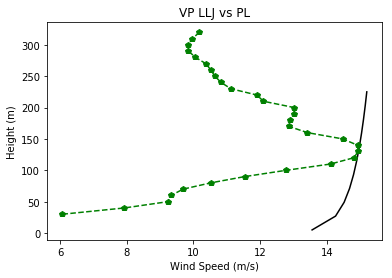

In [38]:
# Inputs
time_of_interest = "2017-02-17 14:40:00"
resamp_size = '10min'
# Plot TurbSim
u_TS2 = []
hs = []
i = 0
for z in kir_ts2.z:
    #print(np.mean(kir_ts.u[:,int(half_ind_y),i]))
    u_TS2 = np.append(u_TS2,np.mean(kir_ts2.u[:,4,i]))
    
    hs = np.append(hs, z)
    i = i + 1
plt.plot(u_TS2,hs,'k',label = 'TurbSim')

# Plot SODAR
resamp = df_sdr["wind speed"].resample(resamp_size).mean()
a = resamp.loc[time_of_interest]

plt.plot(a.values,a.index,"p--g",label = 'SODAR')
plt.ylabel('Height (m)')
plt.xlabel('Wind Speed (m/s)')
plt.title('VP LLJ vs PL')

In [39]:
alpha = 0.143
print('power law exp = ' , alpha)
print('\n')
# Rotor Span
MW10 = [30, 210]
MW5 = [30, 150]
MW3 = [30,150]

################################# 10 MW ###################################
# Average Velocity for LLJ
i = 0
u_add = 0
u_max = 0
for h in range(MW10[0],(MW10[1]+1),10):
    u_now = a[h]
    u_add = u_add + u_now
    if u_now > u_max:
        u_max = u_now
        h_max = h
    i = i + 1 
u_avg_LLJ = u_add/i    
u_max_LLJ = u_max    
print("hmax",h_max)
# Average Velocity for Theory
i = 0
u_add = 0
u_max = 0 
for z in kir_ts2.z:
    if z >=MW10[0] and z <= MW10[1]: 
        u_now = np.float(np.mean(kir_ts2.u[:,:,i]))
        i = i + 1
        u_add = u_add + u_now
        if u_now > u_max:
            u_max = u_now
            h_max = z
        
u_avg_thry = u_add / i
u_max_thry = u_max

avg_dif = 100*np.abs((u_avg_thry - u_avg_LLJ )/ u_avg_LLJ)

print('------------10 MW-------------')
print('AVG vel LLJ: ', u_avg_LLJ)
print('AVG vel THRY: ', u_avg_thry)
print('Percent Diff = ', avg_dif)
print('--')
print('Max vel LLJ: ', u_max_LLJ)
print('Max vel THRY: ', u_max_thry)



################################# 5 MW ###################################
# Average Velocity for LLJ
i = 0
u_add = 0
u_max = 0
for h in range(MW5[0],(MW5[1]+1),10):
    u_now = a[h]
    u_add = u_add + u_now
    if u_now > u_max:
        u_max = u_now
        h_max = h
    i = i + 1 
u_avg_LLJ = u_add/i    
u_max_LLJ = u_max    

# Average Velocity for Theory
i = 0
u_add = 0
u_max = 0 
for z in kir_ts2.z:
    if z >=MW5[0] and z <= MW5[1]: 
        u_now = np.float(np.mean(kir_ts2.u[:,:,i]))
        i = i + 1
        u_add = u_add + u_now
        if u_now > u_max:
            u_max = u_now
            h_max = z
        
u_avg_thry = u_add / i
u_max_thry = u_max
avg_dif = 100*np.abs((u_avg_thry - u_avg_LLJ) / u_avg_LLJ )

print('\n')
print('------------5 MW-------------')
print('AVG vel LLJ: ', u_avg_LLJ)
print('AVG vel THRY: ', u_avg_thry)
print('Percent Diff = ', avg_dif)
print('--')
print('Max vel LLJ: ', u_max_LLJ)
print('Max vel THRY: ', u_max_thry)

power law exp =  0.143


hmax 130
------------10 MW-------------
AVG vel LLJ:  11.98263157894737
AVG vel THRY:  14.591127788506691
Percent Diff =  21.768976141620374
--
Max vel LLJ:  14.94
Max vel THRY:  15.040588680156151


------------5 MW-------------
AVG vel LLJ:  11.565384615384614
AVG vel THRY:  14.363955822064247
Percent Diff =  24.197822206075973
--
Max vel LLJ:  14.94
Max vel THRY:  14.80053440099544


## Generate Turbine Plots

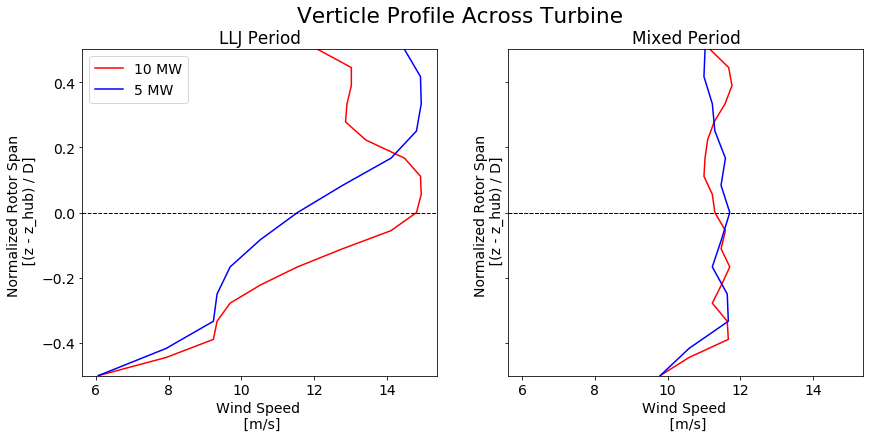

In [161]:
plt.rc("font",size=14)
fig, axs = plt.subplots(nrows=1, ncols=2,sharex=True,sharey=True)    
fig.set_figheight(6)
fig.set_figwidth(14)
plt.axhline(y=0,linewidth=1, color='k',linestyle='--')
############################### LLJ ################################
# Inputs
time_of_interest = "2017-02-17 14:40:00"
resamp_size = '10min'

# Diameter:

# Plot SODAR
resamp = df_sdr["wind speed"].resample(resamp_size).mean()
a = resamp.loc[time_of_interest]
# 10 MW
h_10 = []
u_10 = []
for h in range(MW10[0],(MW10[1]+1),10):
    h_10 = np.append(h_10,(h - 120.0) / (210-30))
    u_10 = np.append(u_10, a[h])
# 5MW
h_5 = []
u_5 = []
for h in range(MW5[0],(MW5[1]+1),10):
    h_5 = np.append(h_5,(h - 90.0) / (150-30))
    u_5 = np.append(u_5, a[h])
        
#fig = plt.figure(figsize=(8,8)) 



axs[0].plot(u_10,h_10,'r',label = '10 MW')
axs[0].plot(u_5,h_5,'b',label = '5 MW')

        
############################### NORMAL ################################
# Inputs
time_of_interest = "2017-02-17 18:20:00"
resamp_size = '10min'

# Diameter:

# Plot SODAR
resamp = df_sdr["wind speed"].resample(resamp_size).mean()
a = resamp.loc[time_of_interest]
# 10 MW
h_10 = []
u_10 = []
for h in range(MW10[0],(MW10[1]+1),10):
    h_10 = np.append(h_10,(h - 120.0) / (210-30))
    u_10 = np.append(u_10, a[h])
# 5MW
h_5 = []
u_5 = []
for h in range(MW5[0],(MW5[1]+1),10):
    h_5 = np.append(h_5,(h - 90.0) / (150-30))
    u_5 = np.append(u_5, a[h])
        
  
    
axs[1].plot(u_10,h_10,'r',label = '10 MW')
axs[1].plot(u_5,h_5,'b',label = '5 MW')
axs[0].legend()    
        
        
axs[0].title.set_text('LLJ Period')
axs[1].title.set_text('Mixed Period')
#plt.legend()
plt.xlabel('Wind Speed \n [m/s]')
plt.ylabel('Normalized Rotor Span \n [(z - z_hub) / D]')
axs[0].set_xlabel('Wind Speed \n [m/s]')
axs[0].set_ylabel('Normalized Rotor Span \n [(z - z_hub) / D]')

plt.ylim(-0.5, 0.5) 
axs[0].axhline(y=0,linewidth=1, color='k',linestyle='--')
axs[1].axhline(y=0,linewidth=1, color='k',linestyle='--')

#axs[0].axes(xticklabels = [-0.5, 0, 0.5])


plt.rc("font",size=18)

fig.suptitle('Verticle Profile Across Turbine')


fig.savefig("../VP_across_turbine.png",bbox_inches="tight",dpi=400)